# BM3D

Python implementation of ["An Analysis and Implementation of the BM3D Image Denoising Method" by Marc Lebrun](https://www.ipol.im/pub/art/2012/l-bm3d/?utm_source=doi).

## Modules

In [122]:
import numpy as np
from skimage import io as skio
import heapq
import pywt
import math
from scipy.linalg import hadamard
import cv2

# local
import matplotlib.pyplot as plt

## Parameters

In [123]:
# 1st step
kHard = 8 #patch size
nHard = 39 #search window size --! era pra ser 39 mas nao entendi como centralizar P
NHard = 16 #max number of similar patches kept 
pHard = 3

sigma = 30
tauHard = 5000 if sigma > 40 else 2500

lambdaHard2d = 0 #hard thresholding for grouping --! ??? where
lambdaHard3d = 2.7

## Initialization

In [124]:
im = skio.imread('./lena.tif') # original image

In [125]:
def noise(im,br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

In [126]:
im = skio.imread('./lena.tif') # original image
imbr = noise(im, sigma) # create noisy image

In [129]:
%%time
#tdqm
basic_estimate = bm3d_1st_step(imbr, sigma, kHard, nHard, lambdaHard2d, lambdaHard3d, tauHard, NHard)

KeyboardInterrupt: 

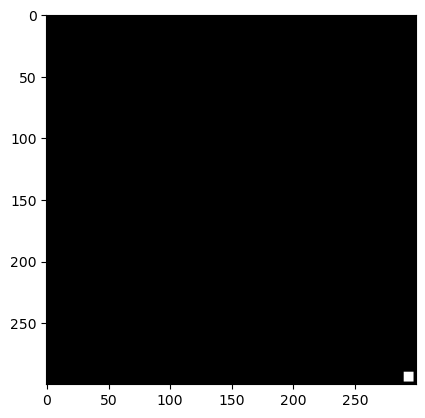

(39, 39)


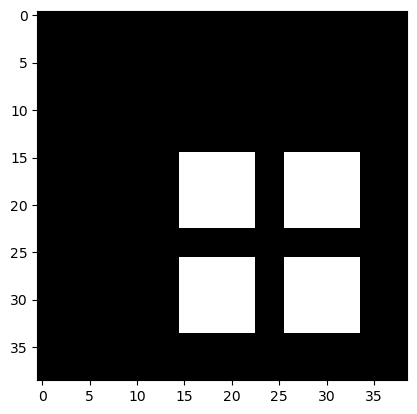

Found exact match for reference patch at offset (15, 15)
Found exact match for reference patch at offset (15, 26)
Found exact match for reference patch at offset (26, 15)
Found exact match for reference patch at offset (26, 26)
[(0.0, (15, 15)), (0.0, (26, 26)), (0.0, (15, 26)), (0.0, (26, 15)), (0.12500000000000003, (15, 25)), (0.12500000000000003, (15, 27)), (0.12500000000000003, (16, 15)), (0.12500000000000003, (25, 26)), (0.12500000000000003, (26, 25)), (0.12500000000000003, (25, 15)), (0.12500000000000003, (16, 26)), (0.12500000000000003, (27, 15)), (0.12500000000000003, (27, 26)), (0.12500000000000003, (26, 27)), (0.12500000000000003, (26, 14)), (0.12500000000000003, (26, 16))] 290 290


In [364]:
test = np.zeros((300,300))
a = np.ones((8,8))
x, y = 290,290
test[x:x+8, y:y+8] += a
plt.imshow(test, cmap='gray')
plt.show()

search_window = get_search_window(test, x, y, patch_size=8, window_size=39)
print(search_window.shape)
plt.imshow(search_window, cmap='gray')
plt.show()

group_3d, coords = build_3d_group(x, y, a, search_window, sigma, lambdaHard2d, tauHard, NHard)

In [365]:
x, y = 0, 306
patch = imbr[x:x+kHard, y:y+kHard]
#plt.imshow(patch, cmap='gray')
#plt.show()
search_window = get_search_window(imbr, x, y, patch_size=kHard, window_size=nHard)
#plt.imshow(search_window, cmap='gray')
#plt.show()

group_3d, coords = build_3d_group(x, y, patch, search_window, sigma, lambdaHard2d, tauHard, NHard)
'''if len(coords) > 0:
    all_groups.append(group_3d)
    all_coords.append(coords)
    '''

Found exact match for reference patch at offset (15, 15)
[(0.0, (15, 15)), (919.2336724346101, (17, 1)), (977.5127969359161, (21, 0)), (1049.7067114754038, (25, 10)), (1063.5069632230666, (4, 7)), (1067.1033003357666, (31, 2)), (1068.9196110838116, (15, 4)), (1102.7435040695912, (14, 13)), (1114.056340614445, (10, 16)), (1115.1878146387057, (0, 8)), (1118.419930669747, (18, 4)), (1121.8791796934336, (29, 8)), (1134.433318520978, (1, 1)), (1143.0981056716887, (18, 2)), (1143.3909750944122, (26, 0)), (1148.6591881614765, (17, 2))] 0 306


'if len(coords) > 0:\n    all_groups.append(group_3d)\n    all_coords.append(coords)\n    '

## The First Denoising Step


### Grouping

In [52]:
# x,y is the top-left corner of the reference patch
# doesnt work well for even window_size --change
def get_search_window(image, x, y, patch_size=kHard, window_size=nHard):
        
    window_top_left_x = x - (window_size//2 - patch_size//2)
    window_top_left_y = y - (window_size//2 - patch_size//2)
    
    search_window = image[
        window_top_left_x: window_top_left_x + window_size,
        window_top_left_y: window_top_left_y + window_size 
    ]
    return search_window, window_top_left_x, window_top_left_y

In [53]:
def hard_thresholding(img, threshold):
    return (abs(img) <= threshold) * img

In [54]:
def distance(p,q):
    return (np.linalg.norm(p-q) ** 2) / (kHard ** 2)

In [55]:
def closest_power_of_two(n, max_n):
    """Find the closest power of 2 to the number n, but not exceeding max_n."""
    if n == 0:
        return 0
    closest_pow2 = 2 ** (math.floor(math.log2(n)))
    return min(closest_pow2, max_n)

In [56]:
def build_3d_group(x, y, p, window, sigma, lambdaHard2d, tauHard, N=NHard):
    closer_N_dists = []

    # assumming square patch and window
    k = p.shape[0]
    n = window.shape[0] 

    if sigma > 40:
        p = hard_thresholding(p, lambdaHard2d * sigma)
    
    for i in range(n-k+1):
        for j in range(n-k+1):
            # get patch Q and calculate distance to ref P
            q = window[i:k+i, j:k+j]
            if sigma > 40:
                q = hard_thresholding(q, lambdaHard2d * sigma)
            
            dist = distance(p, q)
            #print(dist)
            if dist <= tauHard:
                dist_tuple = (-dist, (i, j))  # negate distance to use max-heap
        
                if len(closer_N_dists) < N:
                    heapq.heappush(closer_N_dists, dist_tuple)
                else:
                    if dist_tuple > closer_N_dists[0]:
                        heapq.heappushpop(closer_N_dists, dist_tuple)
    #if len(closer_N_dists)
    closer_N_dists = sorted([(-d, idx) for d, idx in closer_N_dists], key=lambda x: x[0])
    #closer_N_dists = sorted(closer_N_dists, key=lambda x: x[0])
    #print(closer_N_dists, x, y)
    
    coords   = np.array([idx for d, idx in closer_N_dists]) + (x,y)
    group_3d = np.array([window[i:k+i, j:k+j] for d, (i, j) in closer_N_dists])

    N = len(group_3d)
    # check if its power of two and adjust if necessary
    if not (N & (N - 1)) == 0:
        group_size = closest_power_of_two(N, NHard)
        group_3d = group_3d[:group_size]
        coords = coords[:group_size]
    
    return group_3d, coords

In [57]:
def grouping_1st_step(image, sigma, kHard, nHard, lambdaHard2d, tauHard, NHard):
    height, width = image.shape

    # pad image and iterate through original frame
    window_size = nHard
    offset = window_size // 2
    padded_image = np.pad(image, offset, mode='reflect')
      
    all_groups = []
    all_coords = []
    
    # iterate through patches in the image with a step
    for x in range(offset, offset + height - kHard + 1, pHard):
        for y in range(offset , offset + width - kHard + 1, pHard):

            # grouping
            patch = padded_image[x:x+kHard, y:y+kHard]
            search_window, x_win, y_win = get_search_window(padded_image, x, y, patch_size=kHard, window_size=nHard)

            group_3d, coords = build_3d_group(x_win, y_win, patch, search_window, sigma, lambdaHard2d, tauHard, NHard)
            if len(coords) > 0:
                all_groups.append(group_3d)
                all_coords.append(coords)

            # OR FOLLOW CODE FROM HERE

    return all_groups, all_coords

In [59]:
image = imbr
print(image.shape)

window_size = nHard
offset = window_size // 2
padded_image = np.pad(image, offset, mode='reflect')
print(padded_image.shape)

print(image[0][0])
print(padded_image[19][19])

print(offset)

x = offset
y = offset
patch = padded_image[x:x+kHard, y:y+kHard]
search_window, x_win, y_win = get_search_window(padded_image, x, y, patch_size=kHard, window_size=nHard)
group_3d, coords = build_3d_group(x_win, y_win, patch, search_window, sigma, lambdaHard2d, tauHard, NHard)

print(coords)

(512, 512)
(550, 550)
181.75316533250273
181.75316533250273
19
[[19 19]
 [33 23]
 [26  4]
 [19 15]
 [ 4 23]
 [ 8 13]
 [28 23]
 [32 18]
 [19 17]
 [33  9]
 [26 33]
 [26 21]
 [ 6 14]
 [11 32]
 [14 12]
 [26 28]]


In [ ]:
#NAO MUDAAAAAAAAAAAAAAAAAAAAAAAAR
def grouping_1st_step(image, sigma, kHard, nHard, lambdaHard2d, tauHard, NHard):
    height, width = image.shape
    all_groups = []
    all_coords = []
  
#aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
    # iterate through patches in the image with a step
    for x in range(0, height - kHard + 1, pHard):
        for y in range(0, width - kHard + 1, pHard):

            # grouping
            patch = image[x:x+kHard, y:y+kHard]
            search_window = get_search_window(image, x, y, patch_size=kHard, window_size=nHard)

            group_3d, coords = build_3d_group(x, y, patch, search_window, sigma, lambdaHard2d, tauHard, NHard)
            if len(coords) > 0:
                all_groups.append(group_3d)
                all_coords.append(coords)

            # OR FOLLOW CODE FROM HERE

    return all_groups, all_coords

In [60]:
%%time
ag, ac =grouping_1st_step(imbr, sigma, kHard, nHard, lambdaHard2d, tauHard, NHard)

19
CPU times: total: 2min 7s
Wall time: 2min 55s


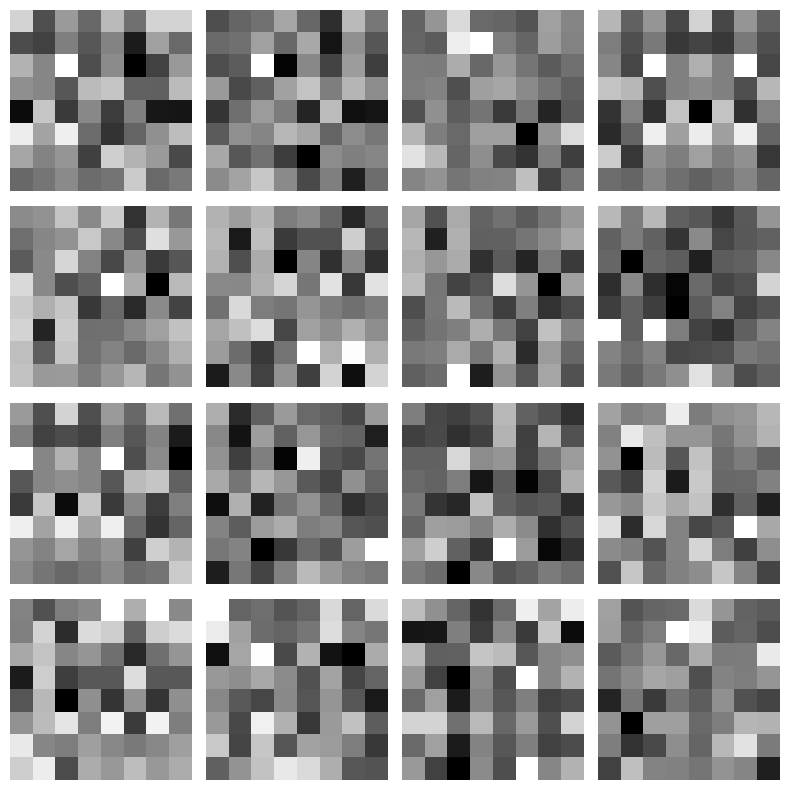

In [61]:
plot_patches(ag[0])

16
[[19 19]
 [33 23]
 [26  4]
 [19 15]
 [ 4 23]
 [ 8 13]
 [28 23]
 [32 18]
 [19 17]
 [33  9]
 [26 33]
 [26 21]
 [ 6 14]
 [11 32]
 [14 12]
 [26 28]]


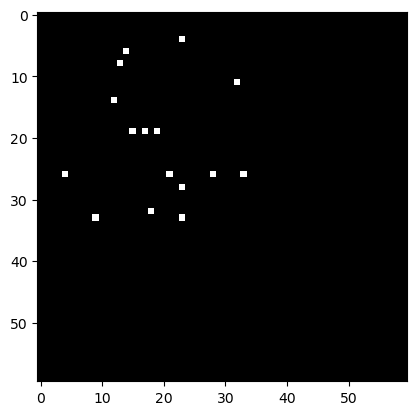

In [63]:
img = np.zeros((60,60))
print(len(ac[0]))
print(ac[0])
x = ac[0][:,0].reshape(-1, 1, 1)
y = ac[0][:,1].reshape(-1, 1, 1)
img[x, y] = 1
plt.imshow(img, cmap='gray')
plt.show()


After the grouping in 1st step, we get a list of tuples formed by: 
- a numpy array (N, 8, 8) where 1 <= N <= NHard (16), which represent a 3d group
- the indeces (i, j) of the reference patch linked to that 3d group 

### --rascunho

In [33]:
search_window = get_search_window(u, 0, 129, patch_size=kHard, window_size=nHard)
group_3d = build_3d_group(u[:kHard, 129:129+kHard], search_window, sigma, lambdaHard2d, tauHard, NHard)
closest_power_of_two(len(group_3d), NHard)

4

In [47]:
for group, coords in a:
    if (group.shape[0] != 16):
        print(group.shape)
        #print(coords)

(4, 8, 8)
(4, 8, 8)
(2, 8, 8)
(1, 8, 8)
(4, 8, 8)
(8, 8, 8)
(2, 8, 8)
(1, 8, 8)
(4, 8, 8)
(8, 8, 8)
(4, 8, 8)
(8, 8, 8)
(8, 8, 8)
(4, 8, 8)
(4, 8, 8)
(1, 8, 8)
(2, 8, 8)
(4, 8, 8)
(4, 8, 8)
(2, 8, 8)
(2, 8, 8)
(4, 8, 8)
(1, 8, 8)
(8, 8, 8)
(4, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(4, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(4, 8, 8)
(2, 8, 8)
(4, 8, 8)
(8, 8, 8)
(4, 8, 8)
(8, 8, 8)
(8, 8, 8)
(4, 8, 8)
(2, 8, 8)
(2, 8, 8)
(2, 8, 8)
(2, 8, 8)
(1, 8, 8)
(1, 8, 8)
(1, 8, 8)
(4, 8, 8)
(8, 8, 8)
(8, 8, 8)
(1, 8, 8)
(2, 8, 8)
(4, 8, 8)
(4, 8, 8)
(2, 8, 8)
(1, 8, 8)
(1, 8, 8)
(8, 8, 8)
(2, 8, 8)
(8, 8, 8)
(2, 8, 8)
(1, 8, 8)
(2, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(4, 8, 8)
(2, 8, 8)
(8, 8, 8)
(2, 8, 8)
(8, 8, 8)
(4, 8, 8)
(2, 8, 8)
(4, 8, 8)
(2, 8, 8)
(1, 8, 8)
(1, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(1, 8, 8)
(8, 8, 8)
(8, 8, 8)
(2, 8, 8)
(4, 8, 8)
(8, 8, 8)
(8, 8, 8)
(4, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(4, 8, 8)
(8, 8, 8)
(4, 8, 8)


In [21]:
print(f'number of 3d groups: {len(a)}')
print(a[100][1])
print(f'example of a 3d group structure: {a[0][0].shape}')
a[0][0][:4]

number of 3d groups: 19893
(0, 384)
example of a 3d group structure: (16, 8, 8)


array([[[150.51422676, 119.75459582, 139.85078503, 144.56725429,
         139.16379532, 191.97839688,  84.96324255, 182.26955673],
        [155.96636967, 109.3751548 , 157.14528814, 144.66045337,
         111.38969795, 129.78675139, 177.26245302,  73.37897212],
        [154.45712715, 146.57562406, 119.0911742 ,  90.85164399,
         156.90363921, 176.97931562,  96.4625209 , 115.40018582],
        [112.36018904, 137.2879943 ,  59.69626921, 134.31859264,
         118.74476782, 143.80647826, 130.46403168, 135.62777515],
        [138.89218706, 176.00025351, 123.891812  , 135.8740748 ,
         164.86574974,  83.90725243, 140.1039221 , 105.94306719],
        [138.73208954, 125.55410166, 112.6029793 ,  55.6681335 ,
         104.41513012, 115.75181142, 141.75601246, 166.03399789],
        [147.97001135, 181.12606421, 101.39075465, 111.71107792,
         132.96484513,  87.87552359,  87.26694695, 146.57052728],
        [155.34648338, 151.51290687, 204.67090018, 120.63194503,
         166.72524

DÚVIDA: como lidar com patches que não formam grupos? acho que quando nenhum Q teve distancia abaixo da threshold. por enquanto vou só ignorar eles 

limitar N a uma potencia de 2 quando nao chega a 16

do we keep the reference patch in its 3d group?

### Collaborative Filtering

After the grouping in 1st step, we have a list of tuples formed by: 
- a numpy array (N, 8, 8) where 1 <= N <= NHard (16), which represent a 3d group
- the indeces (i, j) of the reference patch linked to that 3d group 

In the Collaborative Filtering step, we will perform the following steps for each 3d group:
1. apply a 3D isometric linear transform to the 3d block
2. apply a hard thresholding operator with threshold $\lambda ^{hard} _{3D} \sigma$
3. apply the inverse linear transform
4. save in a buffer the estimate found for each pixel in each patch (this will later be used in the aggregation step)

In [65]:
padded_image = np.pad(imbr, 19, mode='reflect')

height, width = padded_image.shape

nu = np.zeros(padded_image.shape)
delta = np.zeros(padded_image.shape)



This means that the reference patch of size kHard x kHard (8x8) and top-left pixel in (18,489) should be estimated according to the 16 8x8 patches in the 3d group stored in a[1000][0]. 

[[152.33202243  87.49968805 136.30244706 148.8477668   98.61676768
  148.8477668  136.30244706  87.49968805]
 [134.12538473 122.78803072 136.55718196  78.8017717  154.09539026
   78.8017717  136.55718196 122.78803072]
 [119.04076713 107.60994159 149.73473843 129.95801335 141.35996483
  129.95801335 149.73473843 107.60994159]
 [173.40647998 143.117181   114.22592988 166.94473984 133.65685795
  166.94473984 114.22592988 143.117181  ]
 [141.91329245 162.18688572 122.47885199 195.88580473 165.05130776
  195.88580473 122.47885199 162.18688572]
 [164.45960466 100.02410357 127.13375298 129.20616569 129.00383203
  129.20616569 127.13375298 100.02410357]
 [162.87268575 165.06619183 175.40560781 106.56886302 134.86801419
  106.56886302 175.40560781 165.06619183]
 [136.46383023 134.92346051 144.18430806 131.28493374 181.01336968
  131.28493374 144.18430806 134.92346051]]


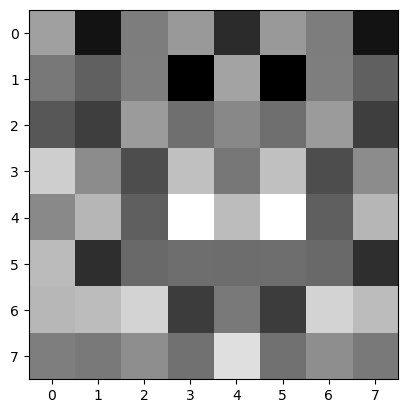

[[ 4.17370743e+00  3.78318242e+00  1.32285000e+01  1.07190042e+01
   1.08987449e+01 -1.26742133e+01  2.58474780e+00 -6.12123837e+00]
 [-1.92759824e+01 -2.06252851e+00  6.95491060e-01  1.99216981e-02
  -3.87096763e+00 -6.78951610e+00 -5.22119236e+00  8.63265563e+00]
 [ 1.78937296e+00 -5.60229100e+00 -1.03511143e+01 -5.16840003e+00
  -5.66250335e+00 -1.21284504e+01  3.33038183e+00  4.90298601e+00]
 [-1.20466199e+01 -2.31803571e+00 -7.74090862e+00  2.43415964e+00
   1.10666458e+01  4.08812226e+00 -1.30546953e+01 -7.21682078e+00]
 [ 3.30372916e+00 -9.04271175e+00 -1.60482895e+01 -1.78431258e+00
   7.25755965e+00  6.76001327e+00  2.18974751e-01  4.08730489e+00]
 [-8.90630746e+00 -6.75695129e+00 -8.53231273e+00  1.26381506e+01
  -6.73831805e+00 -1.44979176e+01 -7.43467619e+00 -3.16839919e+00]
 [ 4.86754946e+00  4.08600126e+00 -3.95234161e+00  1.60802751e+00
  -1.94367906e+00  9.74027623e+00 -6.86856923e+00 -1.15147344e+01]
 [ 1.19619565e+00  1.02995977e-02  6.40944364e-01 -5.64809275e+00
   

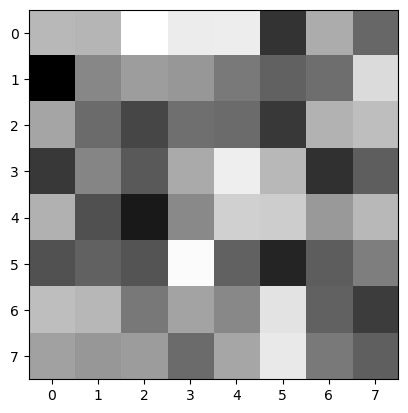

[[-1.45796792e+01 -2.16044702e+00 -1.39797241e+01 -1.64177991e+00
   1.03566674e+01 -1.96173797e+00 -5.75156427e+00 -5.40156439e+00]
 [ 6.19810872e+00  2.34276343e+00  4.36944826e+00 -1.91987682e+01
  -3.88714562e-01 -6.36676366e+00 -8.24241699e+00  8.83601900e+00]
 [ 9.73905023e+00  1.05863099e+01 -3.16048698e+00 -4.48947293e+00
  -1.00287405e+01  2.70876241e+00  1.62087618e-01  1.25725882e+00]
 [ 3.26088395e+00 -7.85654886e-03 -6.98422859e+00 -1.22627181e+01
   8.77691197e+00  5.35952929e+00 -4.23126821e+00  6.08811856e-01]
 [ 1.35724928e+01 -7.23738707e+00 -5.56555755e+00  1.42669292e+01
  -5.20277071e+00 -6.91853685e+00  1.48388165e+00  6.09130166e+00]
 [ 1.19483046e+01  7.26752723e+00 -1.31677087e+01  6.20682523e+00
  -3.61102402e+00  1.13160950e+00 -3.43293544e+00 -5.94694041e-01]
 [ 1.33950966e+00  8.09894547e+00 -8.11919556e+00 -7.51801700e+00
   4.00675948e+00  7.07967493e+00 -6.80003540e+00  5.31992256e+00]
 [ 8.48123419e+00  2.04743421e+00  1.35104579e+01  7.23574391e+00
   

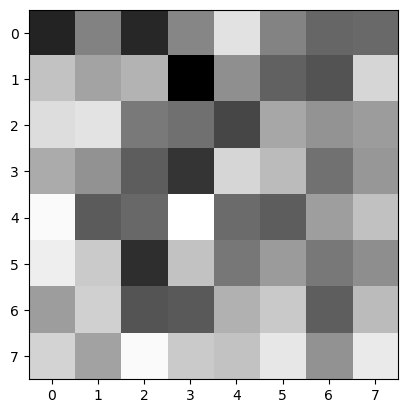

In [103]:
group = a[0]
print(group[0][15])
plt.imshow(group[0][15],cmap='gray')
plt.show()

#plot_patches(group[0])
transformed = np.array([apply_2d_transform(patch, use_dct=True) for patch in group[0]]) #t2d
#transformed.shape
#group_3d, weight = ht_filtering_hadamard(transformed, sigma, lambdaHard3d, True)

#print(transformed[15])
#plt.imshow(transformed[15],cmap='gray')
#plt.show()
#plot_patches(transformed)

#transformed3d=[]
for i in range(transformed.shape[-2]):
    for j in range(transformed.shape[-1]):
        transformed[:, i, j] = apply_1d_transform(transformed[:, i, j]) #t1d
#transformed3d=np.array(transformed3d)

#print(transformed[15])
#plt.imshow(transformed[15], cmap='gray')
#plt.show()
#plot_patches(transformed)

threshold = lambdaHard3d * sigma
after = hard_thresholding(transformed, threshold)
#after = transformed
#print(after[15])
#plt.imshow(after[15], cmap='gray')
#plt.show()
#plot_patches(after)

for i in range(after.shape[-2]):
    for j in range(after.shape[-1]):
        after[:, i, j] = reverse_1d_transform(after[:, i, j]) #t1d

print(after[15])
plt.imshow(after[15], cmap='gray')
plt.show()

final = np.array([reverse_2d_transform(patch, use_dct=True) for patch in after]) #t2d


print(final[15])
plt.imshow(final[15], cmap='gray')
plt.show()

In [112]:
%%time
#def collab_filtering_aggregation():
im = skio.imread('./lena.tif') # original image
imbr = noise(im, sigma) # create noisy image

all_group3d_patches = ag
all_group3d_coords  = ac

imbr = np.pad(imbr, 19, mode='reflect')
height, width = imbr.shape
nu = np.zeros(imbr.shape)
delta = np.zeros(imbr.shape)

print(nu.shape)
thresholds = []

X, Y = np.meshgrid(np.arange(kHard), np.arange(kHard), indexing='ij')

for igroup in range(len(all_group3d_coords)):
    group3d_patches = all_group3d_patches[igroup] # shape (16,8,8)
    group3d_coords  = all_group3d_coords[igroup]  # shape (16,1,2)
    
    #3D TRANSFORM
    transformed = np.array([apply_2d_transform(patch, use_dct=True) for patch in group3d_patches]) #t2d
    for i in range(transformed.shape[-2]):
        for j in range(transformed.shape[-1]):
            transformed[:, i, j] = apply_1d_transform(transformed[:, i, j]) #t1d

    #THRESHOLD
    threshold = lambdaHard3d * sigma
    thresholded = hard_thresholding(transformed, threshold)

    thresholds.append(thresholded)

    ## calculate weights
    NPHard = np.count_nonzero(thresholded)
    weight = 1/NPHard if NPHard >= 1 else 1
    weight = np.array([weight])

    #3D REVERSE
    for i in range(thresholded.shape[-2]):
        for j in range(thresholded.shape[-1]):
            thresholded[:, i, j] = reverse_1d_transform(thresholded[:, i, j]) #t1d
    
    filtered = np.array([reverse_2d_transform(patch, use_dct=True) for patch in thresholded]) #t2d

    ## AGGREGATION BUFFERS UPDATE
    nu, delta = update_aggregation_buffers(nu, delta, filtered, group3d_coords, weight, X, Y)

    

(550, 550)
CPU times: total: 1min 6s
Wall time: 1min 22s


(550, 550)

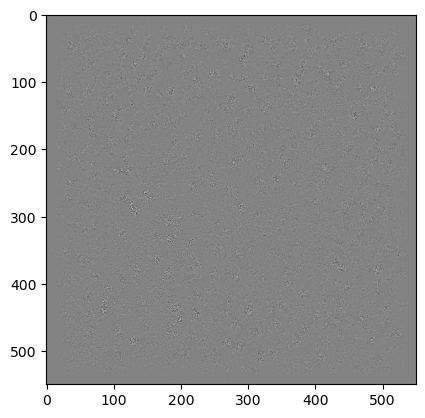

In [113]:
plt.imshow(nu, cmap='gray')
nu.shape

(550, 550)

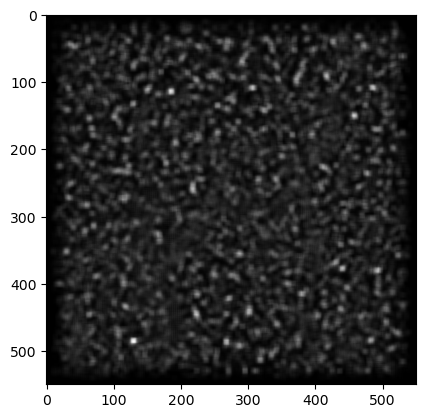

In [114]:
plt.imshow(delta, cmap='gray')
delta.shape

C:\Users\maria\AppData\Local\Temp\ipykernel_33068\352006251.py:2: RuntimeWarning: invalid value encountered in divide
  bc = np.divide(nu, delta, basic)


(550, 550)

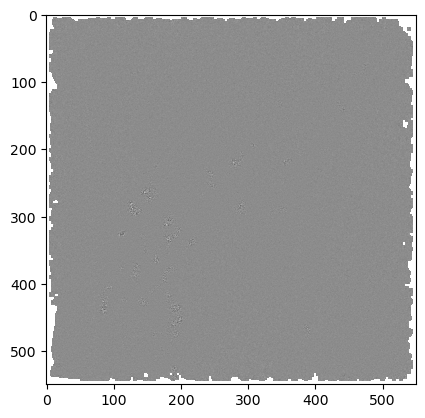

In [115]:
basic = np.zeros((550,550))
bc = np.divide(nu, delta, basic)
basic = np.array(basic)
plt.imshow(basic, cmap='gray')
basic.shape

In [110]:
thresholded
many = np.where( thresholded == 0)
len(many)
thresholded

print(len(ac))
print(len(ag))

print(thresholds[0].shape)
print(len(thresholds))
print(np.sum(thresholds==0))
print(np.count_nonzero(thresholds[180]))

28561
28561
(16, 8, 8)
28561
0
1024


In [ ]:
patches = ag[0]
coords = ac[0]
weights = np.random.rand(16)

# Grid for patch coordinates (kxk for each patch)
X, Y = np.meshgrid(np.arange(kHard), np.arange(kHard), indexing='ij')

In [71]:
def update_aggregation_buffers(nu, delta, patches, coords, weights, X, Y):
    weights = weights.reshape(-1,1,1)
    
    # Offset the grid for each patch position
    X_ = X + coords[:, 0].reshape(-1, 1, 1)  
    Y_ = Y + coords[:, 1].reshape(-1, 1, 1)  
    
    np.add.at(nu, (X_, Y_), patches * weights)
    np.add.at(delta, (X_, Y_), weights) #######
    
    return nu, delta

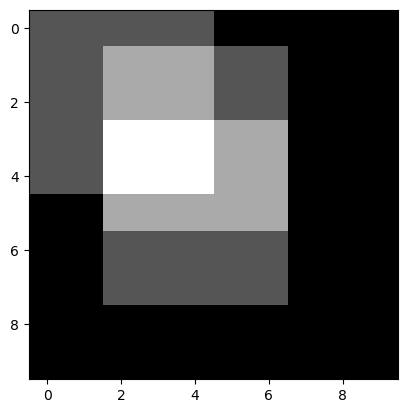

In [265]:
import numpy as np

# Initialize a 10x10 image with zeros
img = np.zeros((10, 10))

# Define patches, weights, and positions
patches = np.random.rand(3, 5, 5)
weights = np.array([0.2, 0.5, 0.83]).reshape(-1, 1, 1)
positions = np.array([[0, 0], [1, 2], [3, 2]])

# Grid for patch coordinates (5x5 for each patch)
X, Y = np.meshgrid(np.arange(5), np.arange(5), indexing='ij')

# Offset the grid for each patch position
X = X + positions[:, 0].reshape(-1, 1, 1)  # Shape (3, 5, 5)
Y = Y + positions[:, 1].reshape(-1, 1, 1)  # Shape (3, 5, 5)

# Apply patches weighted by their respective weights
np.add.at(img, (X, Y), 0.8)

plt.imshow(img, cmap='gray')


In [260]:
x, y = np.meshgrid(np.arange(5), np.arange(5), indexing='ij')
np.add.at(img, (x, y), patches * weights)

print(x)
print(y)

[[2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]
 [5 5 5 5 5]
 [6 6 6 6 6]]
[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]


In [ ]:
group = a[0]
print(group[0][15])

transformed = np.array([apply_2d_transform(patch, use_dct=True) for patch in group[0]]) #t2d

for i in range(transformed.shape[-2]):
    for j in range(transformed.shape[-1]):
        transformed[:, i, j] = apply_1d_transform(transformed[:, i, j]) #t1d

threshold = lambdaHard3d * sigma
after = hard_thresholding(transformed, threshold)

## calculate weights

for i in range(after.shape[-2]):
    for j in range(after.shape[-1]):
        after[:, i, j] = reverse_1d_transform(after[:, i, j]) #t1d

transformed = np.array([reverse_2d_transform(patch, use_dct=True) for patch in after]) #t2d


print(transformed[15])


In [36]:
a=np.zeros((10,10))
b=np.ones((2,3))
coords = (1,0)
print(b)
x, y = coords
patchH, patchW = b.shape
a[x:x+patchH, y:y+patchW] += b
print(a)

[[1. 1. 1.]
 [1. 1. 1.]]
3 2
1 0
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 2. 2. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
'''def collaborative_filtering(group_3d, use_dct=True, threshold=2.7):
    # Apply 2D transform to each patch in the group
    group_3d_transformed = np.array([apply_2d_transform(patch, use_dct) for patch in group_3d])

    # Apply 1D Walsh-Hadamard transform along the third dimension
    group_3d_transformed = apply_1d_walsh_hadamard_transform(group_3d_transformed)

    # Apply hard thresholding
    group_3d_thresholded = hard_thresholding(group_3d_transformed, threshold)

    # Apply inverse 1D Walsh-Hadamard transform
    group_3d_inverse = inverse_1d_walsh_hadamard_transform(group_3d_thresholded)

    # Apply inverse 2D transform to each patch
    group_3d_inverse = np.array([inverse_2d_transform(patch, use_dct) for patch in group_3d_inverse])

    return group_3d_inverse
'''

In [67]:
def apply_1d_transform(array, use_dct=False):
    #if use_dct:
     #   return cv2.dct(array)  # 2D DCT
    #else:
    return fwht(array)

def reverse_1d_transform(array, use_dct=False):
    #if use_dct:
     #   return cv2.dct(array)  # 2D DCT
    #else:
    return ifwht(array)

In [68]:
#fast walsh-hadamard function
def fwht(x):
    h = 1
    while h < len(x):
        for i in range(0, len(x), h * 2):
            for j in range(h):
                x[i + j], x[i + j + h] = x[i + j] + x[i + j + h], x[i + j] - x[i + j + h]
        h *= 2
    return x

def ifwht(x):
    n = len(x)
    x = fwht(x)
    return x / n

#from sympy import fwht

In [69]:
def apply_2d_transform(patch, use_dct=False):
    if use_dct:
        return cv2.dct(patch)  # 2D DCT
    else:
        coeffs = pywt.wavedec2(patch, wavelet='bior1.5', level=2, mode='periodic')
        return coeffs

def reverse_2d_transform(patch, use_dct=False):
    if use_dct:
        return cv2.dct(patch, flags=cv2.DCT_INVERSE)
    else:
        coeffs = pywt.waverec2(patch, wavelet='bior1.5', level=2, mode='periodic')
        return coeffs

In [ ]:
group = a[0][0]
#group_3d_transformed = np.array([apply_2d_transform(patch) for patch in group])
#group_3d_transformed.shape
test = apply_2d_transform(group[0])
group_new.append(transformed_2d) for patch in group
print(test)
print(group.shape)

print(test.shape)
plt.imshow(test, cmap='gray')
'''
for group, coords in a:
    for patch in group:
        transformed_2d = apply_2d_transform(patch)
        thresholded_2d

print(test)
plt.imshow(group[0], cmap='gray')
plt.show()
plt.imshow(test, cmap='gray')
plt.show()
#group[0]'''

error: OpenCV(4.10.0) C:\b\abs_daut97tdpo\croot\opencv-suite_1722029138522\work\modules\core\src\dxt.cpp:4415: error: (-215:Assertion failed) type == CV_32FC1 || type == CV_64FC1 in function 'cv::dct'


In [ ]:
    if (group.shape[0] != 16):
        print(group.shape)
        print(coords)

In [124]:
for group, coords in a:
    group_new = []

    for patch in group:
        transformed_2d = apply_2d_transform(patch)
        group_new.append(transformed_2d) 
    group_new = np.array(group_new)
    #1d transform
    #thresholding
    #1d reverse
    #2d reverse
    #track buffers


(4, 8, 8)
(0, 156)
(8, 8, 8)
(0, 159)
(4, 8, 8)
(0, 255)
(8, 8, 8)
(0, 288)
(2, 8, 8)
(0, 294)
(4, 8, 8)
(0, 303)
(2, 8, 8)
(0, 306)
(8, 8, 8)
(0, 402)
(8, 8, 8)
(0, 423)
(8, 8, 8)
(0, 426)
(1, 8, 8)
(0, 441)
(4, 8, 8)
(0, 450)
(2, 8, 8)
(0, 456)
(8, 8, 8)
(0, 459)
(4, 8, 8)
(0, 501)
(4, 8, 8)
(3, 126)
(4, 8, 8)
(3, 129)
(8, 8, 8)
(3, 156)
(8, 8, 8)
(3, 159)
(8, 8, 8)
(3, 162)
(1, 8, 8)
(3, 165)
(2, 8, 8)
(3, 288)
(1, 8, 8)
(3, 291)
(8, 8, 8)
(3, 294)
(2, 8, 8)
(3, 297)
(4, 8, 8)
(3, 303)
(4, 8, 8)
(3, 321)
(8, 8, 8)
(3, 405)
(8, 8, 8)
(3, 417)
(8, 8, 8)
(3, 423)
(1, 8, 8)
(3, 432)
(1, 8, 8)
(3, 447)
(1, 8, 8)
(3, 453)
(4, 8, 8)
(3, 459)
(8, 8, 8)
(3, 501)
(4, 8, 8)
(6, 240)
(2, 8, 8)
(6, 243)
(8, 8, 8)
(6, 294)
(2, 8, 8)
(6, 297)
(2, 8, 8)
(6, 300)
(4, 8, 8)
(6, 303)
(4, 8, 8)
(6, 306)
(8, 8, 8)
(6, 321)
(4, 8, 8)
(6, 420)
(8, 8, 8)
(6, 423)
(8, 8, 8)
(6, 426)
(4, 8, 8)
(6, 429)
(1, 8, 8)
(6, 444)
(1, 8, 8)
(6, 450)
(2, 8, 8)
(6, 456)
(1, 8, 8)
(6, 459)
(8, 8, 8)
(6, 462)
(8, 8, 8)
(9

In [21]:
apply_2d_transform(a[0][0][0], use_dct=True)

array([[ 1.08460386e+03, -1.85997724e+01, -2.93772830e+01,
         4.71394691e+01, -4.37130392e+01, -2.39976078e+00,
        -1.81498234e+01,  5.96700309e+01],
       [-8.71436084e+00,  1.82210440e+01, -7.45423779e+00,
        -3.68729072e+01,  2.36190666e+01, -1.32459038e+01,
        -1.26931282e+00,  1.62788104e+01],
       [ 2.40016296e+01,  4.28637686e+01,  1.25672219e+00,
         6.65521734e+00,  1.21199509e+01,  1.14943403e+01,
        -1.12341754e+01, -2.87251657e+01],
       [ 3.71604546e+01, -2.99310711e+01,  3.99580794e+01,
         2.88189184e+01, -1.78300243e+01,  3.62332466e+01,
         2.33243283e+01, -1.13349247e+01],
       [ 2.21699881e+01,  2.72202234e+01,  1.16342692e+00,
         1.68857718e-01,  3.01229085e+01, -6.85945647e+01,
        -3.19338735e+01, -2.48773531e+01],
       [ 4.20587655e+00,  4.02333532e+01, -2.40702204e+01,
         2.29566584e+01, -1.32842000e+01, -3.46170604e+00,
         6.37669102e+01, -3.83240493e+01],
       [-2.70914820e+00,  9.843717

### Aggregation

## The Second Denoising Step

### Grouping

### Collaborative Filtering


### Aggregation

## Results

### PSNR: Peak Signal to Noise Ratio

In [37]:
def bior_2d_forward(img):
    """
    :wavelet forward transform
    :param bior_img:
    :return:
    """
    assert img.shape[-1] == img.shape[-2]
    iter_max = int(math.log2(img.shape[-1]))

    coeffs = pywt.wavedec2(img, 'bior1.5', level=iter_max, mode='periodization')
    wave_im = np.zeros_like(img, dtype=np.float64)

    N = 1
    wave_im[..., :N, :N] = coeffs[0]
    for i in range(1, iter_max + 1):
        wave_im[..., N:2 * N, N:2 * N] = coeffs[i][2]
        wave_im[..., 0:N, N: 2 * N] = -coeffs[i][1]
        wave_im[..., N: 2 * N, 0:N] = -coeffs[i][0]
        N *= 2
    return wave_im


def bior_2d_reverse(bior_img):
    """
    :wavelet reverse transform
    :param bior_img:
    :return:
    """
    assert bior_img.shape[-1] == bior_img.shape[-2]
    iter_max = int(math.log2(bior_img.shape[-1]))

    N = 1
    rec_coeffs = [bior_img[..., 0:1, 0:1]]
    for i in range(iter_max):
        LL = bior_img[..., N:2 * N, N:2 * N]
        HL = -bior_img[..., 0:N, N: 2 * N]
        LH = -bior_img[..., N: 2 * N, 0:N]
        t = (LH, HL, LL)
        rec_coeffs.append(t)
        N *= 2

    rec_im = pywt.waverec2(rec_coeffs, 'bior1.5', mode='periodization')
    return rec_im

In [51]:
def ht_filtering_hadamard(group_3D, sigma, lambdaHard3D, doWeight):  # group_3D shape=(n*n, nSx_r)
    """
    :hard threshold filtering after hadamard transform
    :param group_3D:
    :param sigma:
    :param lambdaHard3D:
    :param doWeight:
    :return:
    """
    nSx_r = group_3D.shape[-1]
    coef_norm = math.sqrt(nSx_r)
    coef = 1.0 / nSx_r

    group_3D_h = hadamard_transform(group_3D)

    # hard threshold filtering in this block
    T = lambdaHard3D * sigma * coef_norm
    T_3D = np.where(np.abs(group_3D_h) > T, 1, 0)
    weight = np.sum(T_3D)
    group_3D_h = np.where(np.abs(group_3D_h) > T, group_3D_h, 0.)

    group_3D = hadamard_transform(group_3D_h)

    group_3D *= coef
    if doWeight:
        weight = 1. / (sigma * sigma * weight) if weight > 0. else 1.

    return group_3D, weight


def hadamard_transform(vec):
    n = vec.shape[-1]
    h_mat = hadamard(n).astype(np.float64)
    v_h = vec @ h_mat
    return v_h

In [77]:
import pywt
import numpy as np

test = np.array([[2.,3.,1.,2.],[2.,1.,1.,2.],[2.,3.,1.,3.],[1.,3.,1.,2.]])
coeffs = pywt.wavedec2(test, 'bior1.5', mode='periodic')
# Levels:
print(test)
print(coeffs)

[[2. 3. 1. 2.]
 [2. 1. 1. 2.]
 [2. 3. 1. 3.]
 [1. 3. 1. 2.]]
[array([[2., 3., 1., 2.],
       [2., 1., 1., 2.],
       [2., 3., 1., 3.],
       [1., 3., 1., 2.]])]


In [18]:
import matplotlib.pyplot as plt

def plot_patches(array):
    """
    Plots each 8x8 patch from a (16, 8, 8) array in a 4x4 grid of subplots.
    
    Parameters:
    array (numpy.ndarray): A numpy array of shape (16, 8, 8) representing 16 patches.
    """
    # Ensure the array is of shape (16, 8, 8)
    assert array.shape == (16, 8, 8), "Array must have the shape (16, 8, 8)"
    
    # Create a figure with 4x4 subplots
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))  # 4x4 grid, adjust the size as needed

    # Flatten axs to easily iterate over it
    axs = axs.flatten()

    # Iterate over the 16 patches and plot each one
    for i in range(16):
        axs[i].imshow(array[i], cmap='gray')  # Use cmap='gray' for grayscale
        axs[i].axis('off')  # Turn off the axes for clarity
    
    # Display the figure
    plt.tight_layout()
    plt.show()


In [31]:
a = [1,2,3]
b = [3,4,5,6]

a = np.array(a)
b = np.array(b)
c = np.array(list(zip(a,b)))
for ai, bi in zip(a,b):
    print(ai, bi)

1 3
2 4
3 5


In [32]:
coords = [[0,0],[1,2]]
patches = [

SyntaxError: incomplete input (3332928304.py, line 2)

In [109]:
idx = np.array(list(np.ndindex(3,3))).reshape(3, 3, 2)
idx

array([[[0, 0],
        [0, 1],
        [0, 2]],

       [[1, 0],
        [1, 1],
        [1, 2]],

       [[2, 0],
        [2, 1],
        [2, 2]]])

In [140]:
import numpy as np

m = 3  # Number of matrices
n = 5  # Size of each matrix

# Create a grid of indices for the first two dimensions
j_indices = np.arange(n)[:, np.newaxis]  # Shape (n, 1)
k_indices = np.arange(n)  # Shape (n,)

# Create the 4D array using broadcasting
M = np.zeros((m, n, n, 2), dtype=int)
M[..., 0] = j_indices  # Fill the first channel with row indices
M[..., 1] = k_indices  # Fill the second channel with column indices

# Now M[i] will give you the desired matrix A_i
print(f'M shape: {M.shape}')
img = np.zeros((10,10))
patch = np.ones((5,5))
weight = 0.5

coords = np.array([1,1])

X = np.arange(5)
Y = np.arange(5).reshape(-1, 1)

x = 3
y = 3
#img[X + x, Y + y] += patch
'''print(M[1].shape)
M[1]
coord = np.array((1,2))
#coord = (1,2)
print(coord)
img[*[[1, 2], [3, 4]]] += 1
'''
#img

X + x

M shape: (3, 5, 5, 2)


array([[0, 1, 2, 3, 4],
       [1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6]])

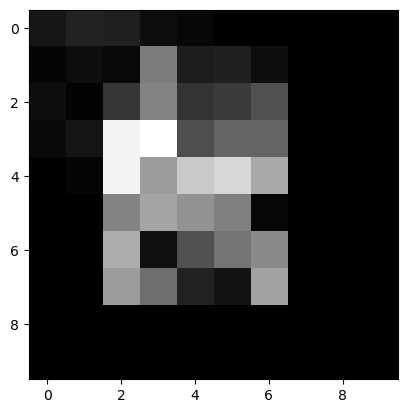

In [152]:
img = np.zeros((10, 10))
patches = np.random.rand(3, 5, 5)
weights = [0.2, 0.5, 0.83]
positions = [[0,0],[1,2],[3,2]]

X = np.arange(5)
Y = np.arange(5).reshape(-1, 1)

N = len(positions)

for i in range(N):
    x, y, patch, weight = *positions[i], patches[i], weights[i]
    img[X + x, Y + y] += patch * weight

plt.imshow(img, cmap = 'gray')

In [24]:
positions = np.array([[0, 0], [1, 2], [3, 2]])

X, Y = np.meshgrid(np.arange(5), np.arange(5), indexing='ij')
print(X)
print(Y)
X = X + positions[:,0].reshape(-1, 1, 1)  # Shape (3, 5, 5)
Y = Y + positions[:,1].reshape(-1, 1, 1)  # Shape (3, 5, 5)
(X,Y)

[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]


(array([[[0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4]],
 
        [[1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4],
         [5, 5, 5, 5, 5]],
 
        [[3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4],
         [5, 5, 5, 5, 5],
         [6, 6, 6, 6, 6],
         [7, 7, 7, 7, 7]]]),
 array([[[0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4]],
 
        [[2, 3, 4, 5, 6],
         [2, 3, 4, 5, 6],
         [2, 3, 4, 5, 6],
         [2, 3, 4, 5, 6],
         [2, 3, 4, 5, 6]],
 
        [[2, 3, 4, 5, 6],
         [2, 3, 4, 5, 6],
         [2, 3, 4, 5, 6],
         [2, 3, 4, 5, 6],
         [2, 3, 4, 5, 6]]]))

<class 'tuple'>
<class 'numpy.ndarray'>
(2, 5, 5)
[[[1 2 3 4 5]
  [1 2 3 4 5]
  [1 2 3 4 5]
  [1 2 3 4 5]
  [1 2 3 4 5]]

 [[4 5 6 7 8]
  [4 5 6 7 8]
  [4 5 6 7 8]
  [4 5 6 7 8]
  [4 5 6 7 8]]]
(10, 10)
[[0.5 0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  1.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]


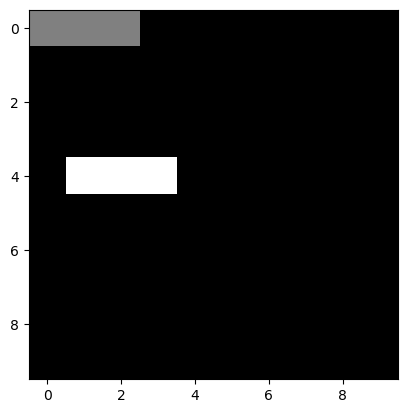

In [115]:
img = np.zeros((10, 10))
X, Y = np.meshgrid(np.arange(5), np.arange(5), indexing='ij')

patches = np.ones((2, 5, 5))
weights = np.array([0.2, 0.5, 0.83]).reshape(-1, 1, 1)
positions = np.array([[0, 0], [1, 2]])

patches = np.ones((2,1,3))
weights = np.array([0.5, 1]).reshape(-1, 1, 1)
positions = np.array([[0,1], [4,4]])

X = X + positions[:,0].reshape(-1, 1, 1)  # Shape (3, 5, 5)
Y = Y + positions[:,1].reshape(-1, 1, 1)  # Shape (3, 5, 5)
print(type((X,Y)))
print(type(X))
print(Y.shape)
print(Y)
print(img.shape)
#print(patches*weights)
#np.add.at(img, ([[[0],[0],[0]],[[4],[4],[4]]],[[[0],[1],[2]],[[1],[2],[3]]]), patches)
np.add.at(img, ([[[0,0,0]],[[4,4,4]]],[[[0,1,2]],[[1,2,3]]]), patches*weights)
#np.add.at(img, (X,Y), patches)

plt.imshow(img, cmap='gray')
print(img)

In [110]:
X, Y = np.meshgrid(np.arange(5), np.arange(5), indexing='ij')
positions = np.array([[0, 0], [1, 2]])
#Y = Y + positions[:,1]  # Shape (3, 5, 5)
#np.add.at(img, ([[[0,0,0]],[[4,4,4]]],[[[0,1,2]],[[1,2,3]]]), patches)
print(X + positions[:,1].reshape(-1,1,1))
(positions[:,1])


[[[0 0 0 0 0]
  [1 1 1 1 1]
  [2 2 2 2 2]
  [3 3 3 3 3]
  [4 4 4 4 4]]

 [[2 2 2 2 2]
  [3 3 3 3 3]
  [4 4 4 4 4]
  [5 5 5 5 5]
  [6 6 6 6 6]]]


array([0, 2])

In [ ]:
import numpy as np
>>> img = np.arange(1000).reshape((20,50))
>>> x = np.full((8,8), np.arange(8))
>>> y = np.full((8,8), np.arange(8))
>>> img[x,y]
array([[  0,  51, 102, 153, 204, 255, 306, 357],
       [  0,  51, 102, 153, 204, 255, 306, 357],
       [  0,  51, 102, 153, 204, 255, 306, 357],
       [  0,  51, 102, 153, 204, 255, 306, 357],
       [  0,  51, 102, 153, 204, 255, 306, 357],
       [  0,  51, 102, 153, 204, 255, 306, 357],
       [  0,  51, 102, 153, 204, 255, 306, 357],
       [  0,  51, 102, 153, 204, 255, 306, 357]])
>>> img[x.T,y]
array([[  0,   1,   2,   3,   4,   5,   6,   7],
       [ 50,  51,  52,  53,  54,  55,  56,  57],
       [100, 101, 102, 103, 104, 105, 106, 107],
       [150, 151, 152, 153, 154, 155, 156, 157],
       [200, 201, 202, 203, 204, 205, 206, 207],
       [250, 251, 252, 253, 254, 255, 256, 257],
       [300, 301, 302, 303, 304, 305, 306, 307],
       [350, 351, 352, 353, 354, 355, 356, 357]])

In [332]:
import numpy as np

def extract_patches(image, patch_size):
    N, _ = image.shape
    m = patch_size
    
    # Create a view of the image as a 2D array of shape (N-m+1, N-m+1, m, m)
    patch_views = np.lib.stride_tricks.sliding_window_view(image, (m, m))
    
    # Reshape the view to get patches in vector form
    patches = patch_views.reshape(-1, m * m)
    
    return patches

# Exemplo de uso:
N = 5  # Tamanho da imagem (N x N)
m = 3  # Tamanho do patch (m x m)
image = np.random.rand(N, N)  # Exemplo de uma imagem aleatória

patches = extract_patches(image, m)

print("Imagem original:")
print(image)
print("\nPatches de tamanho", m, "x", m, "linearizados:")
print(patches.transpose())


Imagem original:
[[0.00373988 0.91222747 0.13937945 0.2006674  0.69795259]
 [0.92683606 0.98143098 0.69750615 0.0616051  0.98199776]
 [0.2461564  0.39309105 0.46772091 0.05703403 0.9617286 ]
 [0.19556687 0.47799578 0.29036966 0.08325164 0.83754122]
 [0.10913783 0.04833794 0.73783921 0.49151665 0.84645361]]

Patches de tamanho 3 x 3 linearizados:
[[0.00373988 0.91222747 0.13937945 0.92683606 0.98143098 0.69750615
  0.2461564  0.39309105 0.46772091]
 [0.91222747 0.13937945 0.2006674  0.98143098 0.69750615 0.0616051
  0.39309105 0.46772091 0.05703403]
 [0.13937945 0.2006674  0.69795259 0.69750615 0.0616051  0.98199776
  0.46772091 0.05703403 0.9617286 ]
 [0.92683606 0.98143098 0.69750615 0.2461564  0.39309105 0.46772091
  0.19556687 0.47799578 0.29036966]
 [0.98143098 0.69750615 0.0616051  0.39309105 0.46772091 0.05703403
  0.47799578 0.29036966 0.08325164]
 [0.69750615 0.0616051  0.98199776 0.46772091 0.05703403 0.9617286
  0.29036966 0.08325164 0.83754122]
 [0.2461564  0.39309105 0.4677

In [128]:
def bm3d_1st_step(image, sigma, kHard, nHard, lambdaHard2d, lambdaHard3d, tauHard, NHard):
    height, width = image.shape

    # pad image and iterate through original frame
    window_size = nHard
    offset = window_size // 2
    padded_image = np.pad(image, offset, mode='reflect')
      
    all_groups = []
    all_coords = []

    nu = np.zeros(padded_image.shape)
    delta = np.zeros(padded_image.shape)

    X, Y = np.meshgrid(np.arange(kHard), np.arange(kHard), indexing='ij')
    
    # iterate through patches in the image with a step
    for x in range(offset, offset + height - kHard + 1, pHard):
        for y in range(offset , offset + width - kHard + 1, pHard):

            # GROUPING
            patch = padded_image[x:x+kHard, y:y+kHard]
            search_window, x_win, y_win = get_search_window(padded_image, x, y, patch_size=kHard, window_size=nHard)

            group3d, coords = build_3d_group(x_win, y_win, patch, search_window, sigma, lambdaHard2d, tauHard, NHard)
            if len(coords) < 1:
                continue

            # COLLABORATIVE FILTERING
            # 3d transform
            transformed = np.array([apply_2d_transform(patch, use_dct=True) for patch in group3d]) #t2d
            for i in range(transformed.shape[-2]):
                for j in range(transformed.shape[-1]):
                    transformed[:, i, j] = apply_1d_transform(transformed[:, i, j]) #t1d

            # thresholding
            threshold = lambdaHard3d * sigma
            thresholded = hard_thresholding(transformed, threshold)

            # calculate weights
            NPHard = np.count_nonzero(thresholded)
            weight = 1/NPHard if NPHard >= 1 else 1
            weight = np.array([weight])

            # 3d reverse
            for i in range(thresholded.shape[-2]):
                for j in range(thresholded.shape[-1]):
                    thresholded[:, i, j] = reverse_1d_transform(thresholded[:, i, j]) #t1d
            
            filtered = np.array([reverse_2d_transform(patch, use_dct=True) for patch in thresholded]) #t2d

            # AGGREGATION 
            nu, delta = update_aggregation_buffers(nu, delta, filtered, coords, weight, X, Y)

    ## BASIC ESTIMATE
    basic = np.divide(nu, delta)

    return basic

In [121]:
x1 = np.arange(9.0).reshape((3, 3))
x2 = np.arange(9.0).reshape((3, 3))

print(x1)
print(x2)

a = np.divide(x1, x2)

print(a)


[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
[[nan  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]


C:\Users\maria\AppData\Local\Temp\ipykernel_33068\14931724.py:7: RuntimeWarning: invalid value encountered in divide
  a = np.divide(x1, x2)
